# Daily Growth Rate Equation Exploration

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cmo
import pandas as pd

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')


In [126]:
# load transformed data
ds_djf_regional = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf_regional[['SST', 'Chl_surf', 'KGP']].sel(length = 40)

#ds_djf_alt = ds_djf_regional[['SST', 'Chl_surf', 'KGP', 'NPP', 'Jint_100m_DIC']]
ds_djf.region

<xarray.DataArray 'region' (region: 5)>
array(['Southern Ocean', 'WAP & Atlantic', 'Atlantic Quadrant', 'SW Atlantic',
       'AP Sector'], dtype='<U17')
Coordinates:
  * region   (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
    length   float64 40.0

In [162]:
region = 'WAP & Atlantic'
ds_djf = ds_djf_regional[['SST', 'Chl_surf', 'KGP']].sel(length = 40, region =region)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    region     <U17 'WAP & Atlantic'
    length     float64 40.0
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [163]:
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_mean

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    region    <U17 'WAP & Atlantic'
    length    float64 40.0
Data variables:
    SST       float64 4.31
    Chl_surf  float64 1.003
    KGP       float64 0.01508

Current mean

In [164]:
ds_curr_mean = (
        ds_djf.sel(time=slice(1980, 2010))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_curr_mean

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    region    <U17 'WAP & Atlantic'
    length    float64 40.0
Data variables:
    SST       float64 4.554
    Chl_surf  float64 1.01
    KGP       float64 0.01537

In [165]:
ds_late_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_late_mean

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    region    <U17 'WAP & Atlantic'
    length    float64 40.0
Data variables:
    SST       float64 6.819
    Chl_surf  float64 1.003
    KGP       float64 0.00845

# Plot Contour Plot of Equation Relationships:

In [166]:
def compute_kgp(sst, chl):
    """Compute Krill Growth Potential for 40mm average adult
    Atkinson et al 2006 
    Natural growth rates in Antarctic krill (Euphausia superba) 
    doi: 10.4319/lo.2006.51.2.0973 
    """
    # specify coefs
    a = -0.066
    b = 0.002
    c = -0.000061
    d = 0.385
    e = 0.328
    f = 0.0078
    g = -0.0101
    
    length = 40.

    # compute terms and sum
    length_term = a + (b * length) + (c * length**2)
    chl_term = d * chl / (e + chl)    
    sst_term = f * sst + g * sst**2    
    kgp = length_term + chl_term + sst_term
   
    #ds['KGP'] = kgp
    return kgp

## Plot in 2D

### Make contour data

In [167]:
sst = np.linspace(-2, 8, 1000)
chl = np.logspace(-2,.2,1000)#np.logspace(-2,.2,1000)

In [168]:
[X, Y] = np.meshgrid(sst, chl)
KGP = compute_kgp(X, Y)

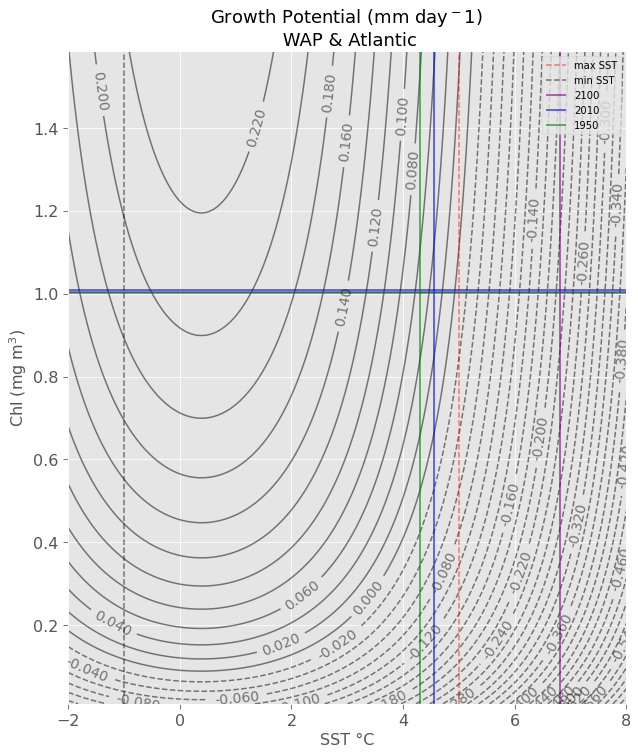

In [169]:

plt.figure(figsize = (10,12))
fmt = '%.3f'
CS = plt.contour(X, Y, KGP, 50, colors='black', alpha=.5)

plt.clabel(CS, inline=True, fontsize=14, fmt=fmt)
#plt.yscale('log')
#Extra
plt.vlines(5, .01, Y.max(), color='r', linestyle = '--', label = 'max SST', alpha = .5)
plt.vlines(-1, .01, Y.max(), color='k', linestyle = '--', label = 'min SST', alpha = .5)
#plt.hlines(0.5, -2, X.max(), color='r', linestyle = '-', label = 'max', alpha = .5)
# Control
plt.hlines(ds_late_mean.Chl_surf, -2, X.max(), color='purple', linestyle = '-', label = '2100', alpha = .75)
plt.vlines(ds_late_mean.SST, .01, Y.max(), color='purple', linestyle = '-', alpha = .75)

plt.hlines(ds_curr_mean.Chl_surf, -2, X.max(), color='b', linestyle = '-', label = '2010', alpha = .75)
plt.vlines(ds_curr_mean.SST, .01, Y.max(), color='b', linestyle = '-', alpha = .75)

plt.hlines(ds_ctrl_mean.Chl_surf, -2, X.max(), color='g', linestyle = '-', alpha = .75)
plt.vlines(ds_ctrl_mean.SST, .01, Y.max(), color='g', linestyle = '-', label = '1950', alpha = .75)

plt.xlabel('SST °C', fontsize = 16)
plt.ylabel('Chl (mg m$^3$)', fontsize = 16)
plt.title(f'Growth Potential (mm day$^{-1}$) \n {region}', fontsize = 18)
plt.legend()
plt.tick_params(axis='both', which='major', length=5, pad=5, labelsize=16);
# --------------------------------------------------------
title = (f'GP-contour-{region}')
path = 'figures/'
file = '.png'
plt.savefig(title + file, bbox_inches='tight')

## Plot in 3D

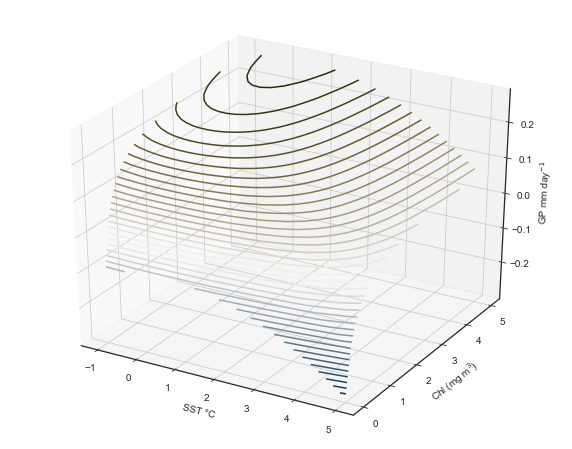

In [294]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')

plt.xlabel('SST °C')
plt.ylabel('Chl (mg m$^3$)');
ax.set_zlabel('GP mm day$^{-1}$')

ax.contour3D(X, Y, KGP, 50, cmap='cmo.diff')


# Plot Observations and Model Data

### Generate Biases Data for Comparison


In [159]:
# observational data
temp_ob = np.array([4.27, 3.59, 3.76])
food_ob = np.array([0.28, 0.36, 0.40])

#model data
temp_mod = np.array([1.39, 1.27, 1.29])
food_mod = np.array([0.28, 0.36, 0.4])

In [160]:
obs_kgp = compute_kgp(temp_ob[0:], food_ob[0:])
obs_kgp

array([-0.05714366,  0.01568568,  0.0144767 ])

In [161]:
mod_kgp = compute_kgp(temp_mod[0:], food_mod[0:])
mod_kgp

array([0.08503042, 0.1114692 , 0.12119305])

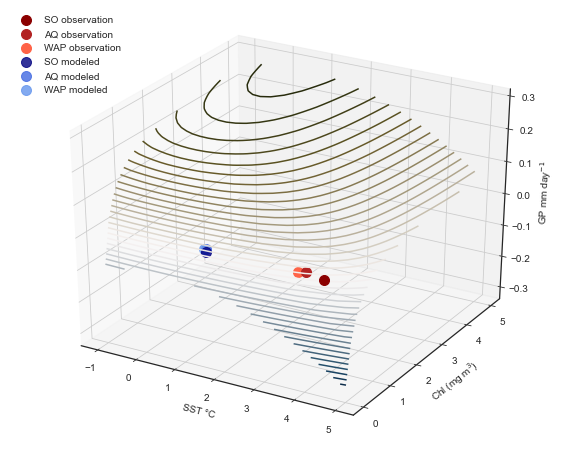

In [292]:
fig = plt.figure(figsize = (10,8))
ax = plt.axes(projection='3d')

ax.scatter(temp_ob[0:1], food_ob[0:1], color = 'darkred', s=100, label = 'SO observation')
ax.scatter(temp_ob[2:], food_ob[2:], color = 'firebrick',s=100, label = 'AQ observation')
ax.scatter(temp_ob[1:2], food_ob[1:2], color = 'tomato', s=100,label = 'WAP observation')

ax.scatter(temp_mod[0:1], food_mod[0:1], color = 'navy', s=100, alpha = .8, label = 'SO modeled')
ax.scatter(temp_mod[2:], food_mod[2:], color = 'royalblue', s=100, alpha = .8, label = 'AQ modeled')
ax.scatter(temp_mod[1:2], food_mod[1:2], color = 'cornflowerblue',s=100, alpha = .8, label = 'WAP modeled')

plt.legend(loc='upper left')
plt.xlabel('SST °C')
plt.ylabel('Chl (mg m$^3$)');
ax.set_zlabel('GP mm day$^{-1}$')

ax.contour3D(X, Y, KGP, 50, cmap='cmo.diff');


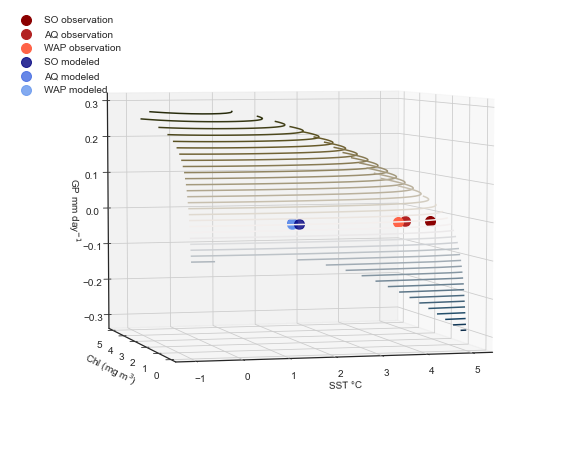

In [293]:
ax.view_init(5, 255)
fig

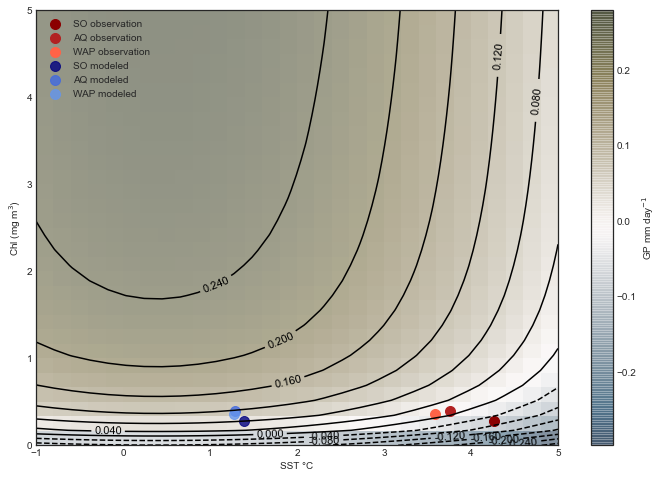

In [278]:
plt.figure(figsize = (12,8))
contours = plt.contour(X, Y, KGP, 15, colors='black')
plt.clabel(contours, inline=True, fontsize=11)

plt.imshow(KGP, extent=[-1, 5, 0, 5], origin='lower',
           cmap='cmo.diff', alpha=0.5)
plt.colorbar(label='GP mm day$^{-1}$', shrink = 1)

plt.scatter(temp_ob[0:1], food_ob[0:1], color = 'darkred', s=100, label = 'SO observation')
plt.scatter(temp_ob[2:], food_ob[2:], color = 'firebrick',s=100, label = 'AQ observation')
plt.scatter(temp_ob[1:2], food_ob[1:2], color = 'tomato', s=100,label = 'WAP observation')

plt.scatter(temp_mod[0:1], food_mod[0:1], color = 'navy', s=100, alpha = .8, label = 'SO modeled')
plt.scatter(temp_mod[2:], food_mod[2:], color = 'royalblue', s=100, alpha = .8, label = 'AQ modeled')
plt.scatter(temp_mod[1:2], food_mod[1:2], color = 'cornflowerblue',s=100, alpha = .8, label = 'WAP modeled')

plt.legend(loc='upper left')
plt.xlabel('SST °C')
plt.ylabel('Chl (mg m$^3$)');
